# ROBERTA 54 NEURONI

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import io
from google.colab import drive 

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler

!pip install transformers
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


     |████████████████████████████████| 2.8 MB 11.4 MB/s 
     |████████████████████████████████| 895 kB 42.9 MB/s 
     |████████████████████████████████| 50 kB 6.7 MB/s 
     |████████████████████████████████| 3.3 MB 51.0 MB/s 
     |████████████████████████████████| 636 kB 44.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


RoBERTa con 54 neuroni:

1 layer di 48 neuroni, 6 neuroni in output layer, 80 batch size, 5 epoch

Epoch 1/5
 1003s - loss: 0.3795 - accuracy: 0.8637 - val_loss: 0.1739 - val_accuracy: 0.9345

Epoch 2/5
 1002s - loss: 0.1295 - accuracy: 0.9508 - val_loss: 0.1642 - val_accuracy: 0.9340

Epoch 3/5
 1001s - loss: 0.1169 - accuracy: 0.9544 - val_loss: 0.1667 - val_accuracy: 0.9320

Epoch 4/5
 1001s - loss: 0.1091 - accuracy: 0.9583 - val_loss: 0.1560 - val_accuracy: 0.9380

Epoch 5/5
 1001s - loss: 0.0898 - accuracy: 0.9650 - val_loss: 0.1754 - val_accuracy: 0.9370

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train_data = pd.read_csv('gdrive/My Drive/BERT/train.txt', header =None, sep =';', names = ['text','emotion'], encoding='utf-8')
test_data = pd.read_csv('gdrive/My Drive/BERT/test.txt',header =None, sep =';', names = ['text','emotion'], encoding='utf-8')
val_data = pd.read_csv('gdrive/My Drive/BERT/val.txt', header =None, sep =';', names = ['text','emotion'], encoding='utf-8')

In [ ]:
train_data.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     16000 non-null  object
 1   emotion  16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB


In [ ]:
train_data.shape

(16000, 2)

In [ ]:
val_data.shape

(2000, 2)

In [ ]:
test_data.shape

(2000, 2)

In [ ]:
train_data['emotion'].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: emotion, dtype: int64

In [ ]:
ros = RandomOverSampler(random_state=42)
train_x, train_y = ros.fit_resample(np.array(train_data['text']).reshape(-1, 1), np.array(train_data['emotion']).reshape(-1, 1));
train = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text', 'emotion']);

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
ohe = preprocessing.OneHotEncoder()
y_train= ohe.fit_transform(np.array(train['emotion']).reshape(-1, 1)).toarray()
y_test= ohe.fit_transform(np.array(test_data['emotion']).reshape(-1, 1)).toarray()
y_val= ohe.fit_transform(np.array(val_data['emotion']).reshape(-1, 1)).toarray()

In [ ]:
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
def tokenize(data,maximum_length) :
  input_ids = []
  attention_masks = []
  for i in range(len(data.text)):
      encoded = tokenizer.encode_plus( 
        data.text[i],
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,
        return_attention_mask=True,
      )
      input_ids.append(encoded['input_ids'])
      attention_masks.append(encoded['attention_mask'])
  return np.array(input_ids),np.array(attention_masks)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


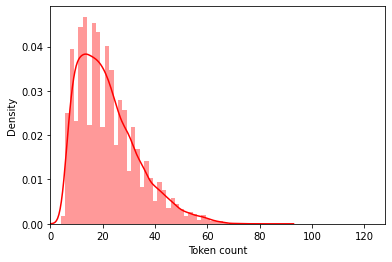

In [ ]:
token_lens = []
for txt in train_data.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))
sns.distplot(token_lens, color='red');
plt.xlim([0, 128]);
plt.xlabel('Token count');

In [ ]:
max_len=np.max(token_lens)
max_len

88

In [ ]:
max_len=90

In [ ]:
train_input_ids,train_attention_masks = tokenize(train, max_len)
test_input_ids,test_attention_masks = tokenize(test_data, max_len)
val_input_ids,val_attention_masks = tokenize(val_data, max_len)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
def create_model(bert_model, max_len):
    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(48, activation=tf.nn.relu)(output)
    output = tf.keras.layers.Dropout(0.1)(output)
    output = tf.keras.layers.Dense(6, activation=tf.nn.softmax)(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(learning_rate=5e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/657M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
model = create_model(roberta_model, max_len)
model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

In [ ]:
history = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_val), epochs=5,batch_size=80)

Epoch 1/5
403/403 [==============================] - 1003s 2s/step - loss: 0.3795 - accuracy: 0.8637 - val_loss: 0.1739 - val_accuracy: 0.9345
Epoch 2/5
403/403 [==============================] - 1002s 2s/step - loss: 0.1295 - accuracy: 0.9508 - val_loss: 0.1642 - val_accuracy: 0.9340
Epoch 3/5
403/403 [==============================] - 1001s 2s/step - loss: 0.1169 - accuracy: 0.9544 - val_loss: 0.1667 - val_accuracy: 0.9320
Epoch 4/5
403/403 [==============================] - 1001s 2s/step - loss: 0.1091 - accuracy: 0.9583 - val_loss: 0.1560 - val_accuracy: 0.9380
Epoch 5/5
403/403 [==============================] - 1001s 2s/step - loss: 0.0898 - accuracy: 0.9650 - val_loss: 0.1754 - val_accuracy: 0.9370


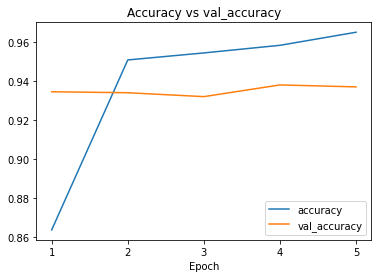

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

accuracy = [0.8637, 0.9508, 0.9544, 0.9583, 0.9650]
val_accuracy= [0.9345, 0.9340, 0.9320, 0.9380, 0.9370]

epoch=[1,2,3,4,5]
fig,ax = plt.subplots()
ax.plot(epoch, accuracy, label='accuracy')
ax.plot(epoch, val_accuracy, label='val_accuracy')
ax.set_title('Accuracy vs val_accuracy')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel('Epoch')
ax.set_ylabel('')
ax.legend(loc='lower right')
plt.show()

In [ ]:
result = model.predict([test_input_ids,test_attention_masks])
y_pred = np.zeros_like(result)
y_pred[np.arange(len(result)), result.argmax(1)] = 1

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy ', accuracy)
f1 = f1_score(y_test, y_pred, average = 'macro')
print('F1 Score :', f1)

Accuracy  0.931
F1 Score : 0.8975843155561126


In [ ]:
y_test_lab = ohe.inverse_transform(y_test)

In [ ]:
y_pred_lab = ohe.inverse_transform(y_pred)
y_pred_lab

array([['sadness'],
       ['sadness'],
       ['sadness'],
       ...,
       ['joy'],
       ['joy'],
       ['surprise']], dtype=object)

In [ ]:
classification_report(y_test_lab,y_pred_lab)

'              precision    recall  f1-score   support\n\n       anger       0.92      0.96      0.94       275\n        fear       0.89      0.90      0.89       224\n         joy       1.00      0.90      0.95       695\n        love       0.75      0.99      0.85       159\n     sadness       0.98      0.96      0.97       581\n    surprise       0.70      0.89      0.79        66\n\n    accuracy                           0.93      2000\n   macro avg       0.87      0.93      0.90      2000\nweighted avg       0.94      0.93      0.93      2000\n'

                 precision    recall  f1-score   support

       anger       0.92      0.96      0.94       275
        fear       0.89      0.90      0.89       224
         joy       1.00      0.90      0.95       695
        love       0.75      0.99      0.85       159
     sadness       0.98      0.96      0.97       581
    surprise       0.70      0.89      0.79        66

    accuracy                           0.93      2000
   macro avg       0.87      0.93      0.90      2000
weighted avg       0.94      0.93      0.93      2000



Ora dobbiamo estrarre le etichette numerate come interi a partire dalle etichette trasformate in OHE.<br>
Per prima cosa creiamo delle versioni numerate intere a partire da OHE:

In [ ]:
y_pred_label = np.argmax(y_pred, axis = 1)
y_test_label = np.argmax(y_test, axis = 1)

Per esempio, guardiamo le prime 5 emozioni del vettore y_pred encodate in 3 modi diversi:

encoding con OHE:

In [ ]:
y_pred[:5]

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

encoding con numeri interi

In [ ]:
y_pred_label[:5]

array([4, 4, 4, 2, 4])

emozioni originali

In [ ]:
y_pred_lab[:10]

array([['sadness'],
       ['sadness'],
       ['sadness'],
       ['joy'],
       ['sadness'],
       ['fear'],
       ['anger'],
       ['love'],
       ['joy'],
       ['anger']], dtype=object)

Guardando i diversi encoding, possiamo capire che la relazione tra le etichette intere e le emozioni originali sono:

sadness=4
joy=2
fear=1
anger=0
surprise=5
love=3


In [ ]:
feels=['anger', 'fear','joy','love','sadness','surprise']

In [ ]:
conf_matrix=confusion_matrix(y_pred_lab,y_test_lab)
conf_matrix

array([[263,   5,   1,   1,  17,   0],
       [  9, 201,   0,   0,   9,   7],
       [  0,   0, 626,   0,   0,   0],
       [  0,   0,  53, 158,   0,   0],
       [  3,   1,   7,   0, 555,   0],
       [  0,  17,   8,   0,   0,  59]])

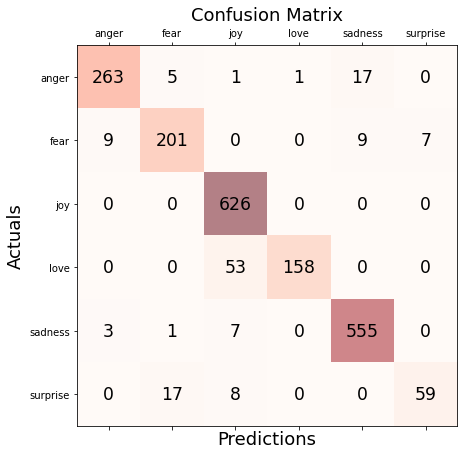

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.matshow(conf_matrix, cmap=plt.cm.Reds, alpha=0.5)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
ax.set_xticklabels(['']+feels)
ax.set_yticklabels(['']+feels)
plt.title('Confusion Matrix', fontsize=18)
plt.show()